In [2]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import haversine_distances
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import pandas
import tweetdf
import geopandas
import regions
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import numpy as np
import importlib
from shapely.geometry import Polygon

In [3]:
all_tweets = tweetdf.from_csv("../../dbs/Sweden.csv").dropna()

In [4]:
tweets = geopandas.GeoDataFrame(
    all_tweets,
    crs="EPSG:4326",
    geometry=geopandas.points_from_xy(all_tweets.longitude, all_tweets.latitude),
)

In [5]:
# Count number of tweets per user
tweets = tweets.merge(
    tweets.groupby('userid', as_index=False).count()[['userid', 'tweetid']].rename(columns={'tweetid': 'tweet_count'}),
    on='userid'
)

In [6]:
# Assign each user to a quantile based on number of tweets
# 9 is a empirically found value to produce evenly sized quantiles
tweets = tweets.assign(quantile=pandas.qcut(tweets['tweet_count'], q=9))

In [7]:
def cluster_tweets(df, eps_km=0.1, min_samples=1):
    kms_per_radian = 6371.0088
    coords = df[['latitude', 'longitude']].values
    return DBSCAN(eps=eps_km/kms_per_radian, min_samples=min_samples, metric='haversine').fit(np.radians(coords))

In [8]:
def cluster_spatial(tws, eps_km=0.1, min_samples=1):
    cls = cluster_tweets(tws, eps_km=eps_km, min_samples=min_samples)
    labels = pandas.Series(cls.labels_)
    return tws.assign(region=pandas.Series(cls.labels_, index=tws.index).values)

In [9]:
regions = tweets.groupby('userid', as_index=False).apply(cluster_spatial)

In [10]:
regions = regions.assign(label=np.full(shape=regions.shape[0], fill_value="other"))

In [11]:
def plot_label_distrib(region_df):
    region_df.groupby(['quantile', 'label']).size().unstack().fillna(0).plot(kind='barh', stacked=True, figsize=(15,7))

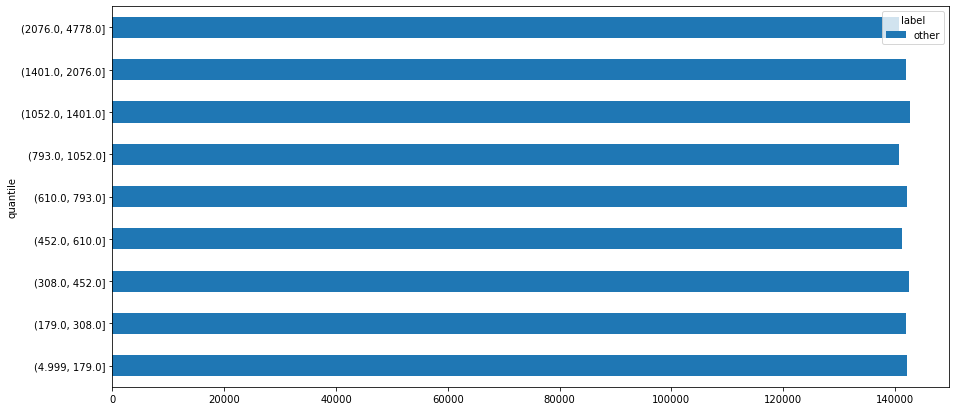

In [12]:
plot_label_distrib(regions)

In [13]:
def during_home(df):
    weekdays = (df['weekday'] < 6) & (0 < df['weekday'])
    weekends = (df['weekday'] == 6) | (0 == df['weekday'])
    morning_evening = (df['hourofday'] < 10) | (17 < df['hourofday'])
    return df[((weekdays) & (morning_evening)) | (weekends)]

def label_home(df):
    print("copying")
    dfc = df.copy(deep=True)
    print("reindex")
    dfc = dfc.set_index(['userid', 'region', 'tweetid']).sort_index()
    print("largest cluster")
    homeidx = during_home(dfc)\
        .groupby(['userid', 'region']).size() \
        .groupby('userid').nlargest(1) \
        .index.tolist()
    print(len(homeidx))
    print("set values")
    keys = [(userid, regionid) for (_, userid, regionid) in homeidx]
    dfc.loc[keys, 'label'] = "home"
    #for (_, userid, regionid) in homeidx:
    #    dfc.loc[(userid, regionid), 'label'] = "home"
    return dfc

In [14]:
regions_home = label_home(regions)

copying
reindex
largest cluster
3480
set values


ValueError: operands could not be broadcast together with shapes (3480,2) (3,) (3480,2) 

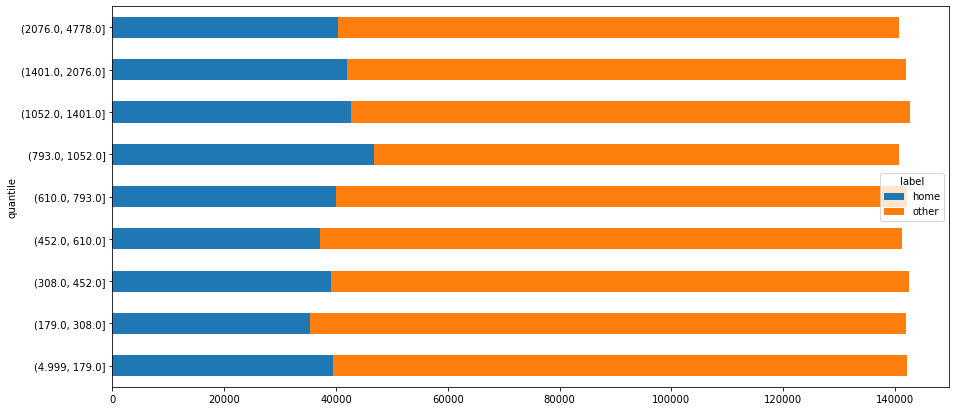

In [229]:
plot_label_distrib(regions_home)

In [ ]:
regions_subset = regions[regions['userid'].isin(regions['userid'].unique()[:100])]

In [146]:
during_home(regions_subset).groupby('userid')

userid             tweetid                  createdat   latitude  \
0       14153467         24287237314  2010-09-12 16:23:34+02:00  59.622270   
2       14153467         24841441028  2010-09-18 13:35:11+02:00  59.610506   
9       14153467         25496170716  2010-09-25 15:04:57+02:00  59.650051   
10      14153467         25496193777  2010-09-25 15:05:14+02:00  59.644326   
11      14153467         25518437137  2010-09-25 19:46:02+02:00  59.610471   
...          ...                 ...                        ...        ...   
41305  100195044  759070508667330560  2016-07-29 18:58:06+02:00  57.307890   
41306  100195044  759073180229271552  2016-07-29 19:08:43+02:00  57.307890   
41307  100195044  759078563626622976  2016-07-29 19:30:07+02:00  57.307890   
41308  100195044  759823587641556992  2016-07-31 20:50:34+02:00  55.540510   
41311  100195044  786613204474531841  2016-10-13 19:02:57+02:00  60.691120   

       longitude  month  weekday  hourofday          timezone  \
0      16.503370    9.0      0.0       16.0  Europe/Stockholm   
2      16.546578    9.0      6.0       13.0  Europe/Stockholm   
9      17.932262    9.0      6.0       15.0  Europe/Stockholm   
10     17.928035    9.0      6.0       15.0  Europe/Stockholm   
11     16.546140    9.0      6.0       19.0  Europe/Stockholm   
...          ...    ...      ...        ...               ...   
41305  13.897088    7.0      5.0       18.0  Europe/Stockholm   
41306  13.897088    7.0      5.0       19.0  Europe/Stockholm   
41307  13.897088    7.0      5.0       19.0  Europe/Stockholm   
41308  13.365522    7.0      0.0       20.0  Europe/Stockholm   
41311  17.132737   10.0      4.0       19.0  Europe/Stockholm   

                        geometry  tweet_count          quantile  region  label  
0      POINT (16.50337 59.62227)          479    (452.0, 610.0]       0  other  
2      POINT (16.54658 59.61051)          479    (452.0, 610.0]       2  other  
9      POINT (17.93226 59.65005)          479    (452.0, 610.0]       5  other  
10     POINT (17.92804 59.64433)          479    (452.0, 610.0]       6  other  
11     POINT (16.54614 59.61047)          479    (452.0, 610.0]       2  other  
...                          ...          ...               ...     ...    ...  
41305  POINT (13.89709 57.30789)         1074  (1052.0, 1401.0]       2  other  
41306  POINT (13.89709 57.30789)         1074  (1052.0, 1401.0]       2  other  
41307  POINT (13.89709 57.30789)         1074  (1052.0, 1401.0]       2  other  
41308  POINT (13.36552 55.54051)         1074  (1052.0, 1401.0]     106  other  
41311  POINT (17.13274 60.69112)         1074  (1052.0, 1401.0]     109  other  

[29352 rows x 14 columns]

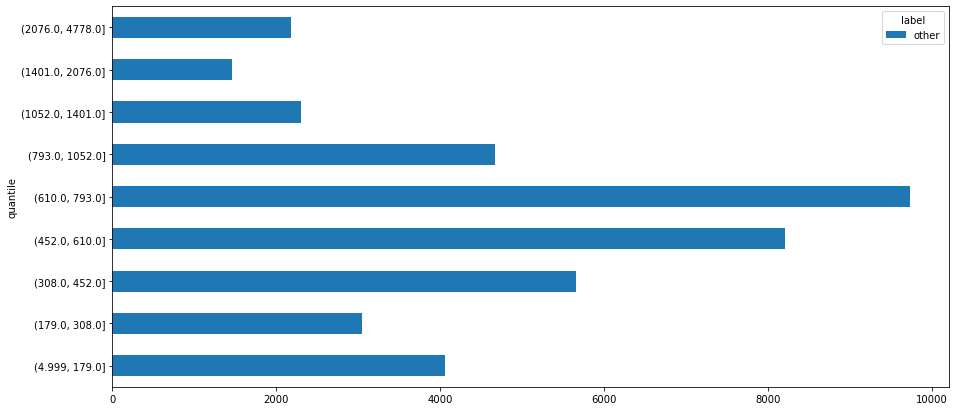

In [109]:
plot_label_distrib(regions_subset)

In [17]:
activities = activities.reset_index(drop=True)

In [18]:
activities = activities.merge(
    activities.groupby('userid', as_index=False).count()[['userid','tweetid']].rename(columns={"tweetid": "tweet_count"}), 
    on='userid'
)

In [19]:
activities

userid             tweetid                  createdat  \
0                      5616  306814580301119488  2013-02-27 18:14:30+01:00   
1                      5616  596331871241379840  2015-05-07 17:12:52+02:00   
2                      5616  623057810864111616  2015-07-20 11:12:12+02:00   
3                      5616  679673567416565760  2015-12-23 15:43:00+01:00   
4                      5616  757647103011262465  2016-07-25 20:42:00+02:00   
...                     ...                 ...                        ...   
1276010  806822309478727680  815619064613609472  2017-01-01 19:01:53+01:00   
1276011  806822309478727680  815835652486938624  2017-01-02 09:22:31+01:00   
1276012  806822309478727680  815937364736380928  2017-01-02 16:06:41+01:00   
1276013  806822309478727680  816003760006668288  2017-01-02 20:30:31+01:00   
1276014  806822309478727680  817472176437608448  2017-01-06 21:45:29+01:00   

          latitude  longitude  month  weekday  hourofday  \
0        57.599221  18.436371    2.0      3.0       18.0   
1        57.599221  18.436371    5.0      4.0       17.0   
2        57.599221  18.436371    7.0      1.0       11.0   
3        57.599221  18.436371   12.0      3.0       15.0   
4        57.599221  18.436371    7.0      1.0       20.0   
...            ...        ...    ...      ...        ...   
1276010  57.716700  12.916700    1.0      0.0       19.0   
1276011  57.716700  12.916700    1.0      1.0        9.0   
1276012  57.716700  12.916700    1.0      1.0       16.0   
1276013  57.730060  12.942200    1.0      1.0       20.0   
1276014  56.675600  12.854990    1.0      5.0       21.0   

                          geometry  cluster  cluster_size  distance_km  \
0        POINT (18.43637 57.59922)        0            10   197.864765   
1        POINT (18.43637 57.59922)        0            10   197.864765   
2        POINT (18.43637 57.59922)        0            10   197.864765   
3        POINT (18.43637 57.59922)        0            10   197.864765   
4        POINT (18.43637 57.59922)        0            10   197.864765   
...                            ...      ...           ...          ...   
1276010  POINT (12.91670 57.71670)        7             5   698.834252   
1276011  POINT (12.91670 57.71670)        7             5   698.834252   
1276012  POINT (12.91670 57.71670)        7             5   698.834252   
1276013  POINT (12.94220 57.73006)        8             1   695.809625   
1276014  POINT (12.85499 56.67560)        9             1   787.142658   

         tweet_count  
0               2171  
1               2171  
2               2171  
3               2171  
4               2171  
...              ...  
1276010           44  
1276011           44  
1276012           44  
1276013           44  
1276014           44  

[1276015 rows x 13 columns]

## Distance from home

The below plot (note log-scale) indicates an overrepresentation of activities close to home. 

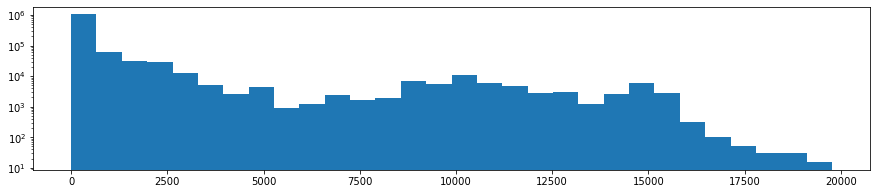

In [43]:
fig, ax = plt.subplots(1, figsize=(15,3))
_ = ax.hist(activities['distance_km'], bins=30, log=True)

## Classification

In line with paper (insert reference) we classify each activity into 5 categories. 
* Home
* Fixed close
* Fixed far
* Flexible close
* Flexible far

A fixed location is a location that have been visited often. Currently we define "often" as a location that have been visited more than a specific number of times. It would be interesting to see difference if percentage-based cutoff point is used. 

A close location is a location that lies within 5km from home.

In [29]:
home = activities['distance_km'] < 0.01
close = (activities['distance_km'] < 5)
fixed = (activities['cluster_size'] > 5)
s = pandas.Series(np.zeros(activities.shape[0], dtype=str))
s[close & fixed] = "fixed-close"
s[~close & fixed] = "fixed-far"
s[close & ~fixed] = "flex-close"
s[~close & ~fixed] = "flex-far"
s[home] = "home"
activities = activities.assign(category=s)

### Distribution

There is an even split between fixed and flexible locations.
However, there are more "far" locations than "close".

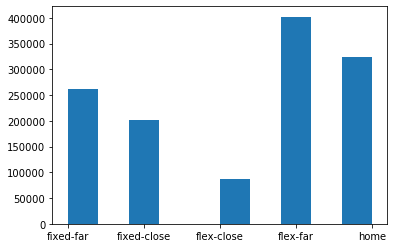

In [32]:
_ = plt.hist(activities['category'])

The distribution varies depending on the number of geotagged tweets a user have.
Fixed locations are more frequent the more tweets a user have. This is expected due to the absolute value cutoff for "fixed" vs "flexible" locations.
Number of geotagged tweets at home also increases as number of tweets increases.

In [68]:
activities = activities.assign(quantile=pandas.qcut(activities['tweet_count'], q=10))

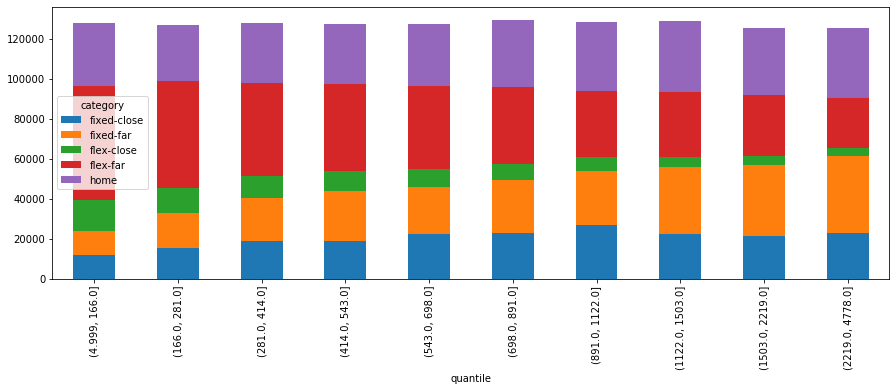

In [69]:
fig, ax = plt.subplots(figsize=(15, 5))
activities.groupby(['quantile', 'category']).size().unstack().fillna(0).plot(kind="bar", stacked=True, ax=ax)


In [91]:
def plot_category_distrib_quantiles(tws):
    grouped = tws.groupby('quantile')
    fig, axes = plt.subplots(nrows=grouped.ngroups, ncols=2, figsize=(15,50))
    idx = 0
    for key in grouped.groups.keys():
        ts = grouped.get_group(key)
        weekdays = ts[(ts['weekday'] < 6) & (0 < ts['weekday'])]
        weekends = ts[(ts['weekday'] == 6) | (0 == ts['weekday'])]
        axes[idx, 0].set_title("Weekdays - " + str(key))
        weekdays.groupby(['hourofday', 'category']).size().unstack().fillna(0).plot(ax=axes[idx, 0])
        axes[idx, 1].set_title("Weekends - " + str(key))
        weekends.groupby(['hourofday', 'category']).size().unstack().fillna(0).plot(ax=axes[idx, 1])
        idx += 1

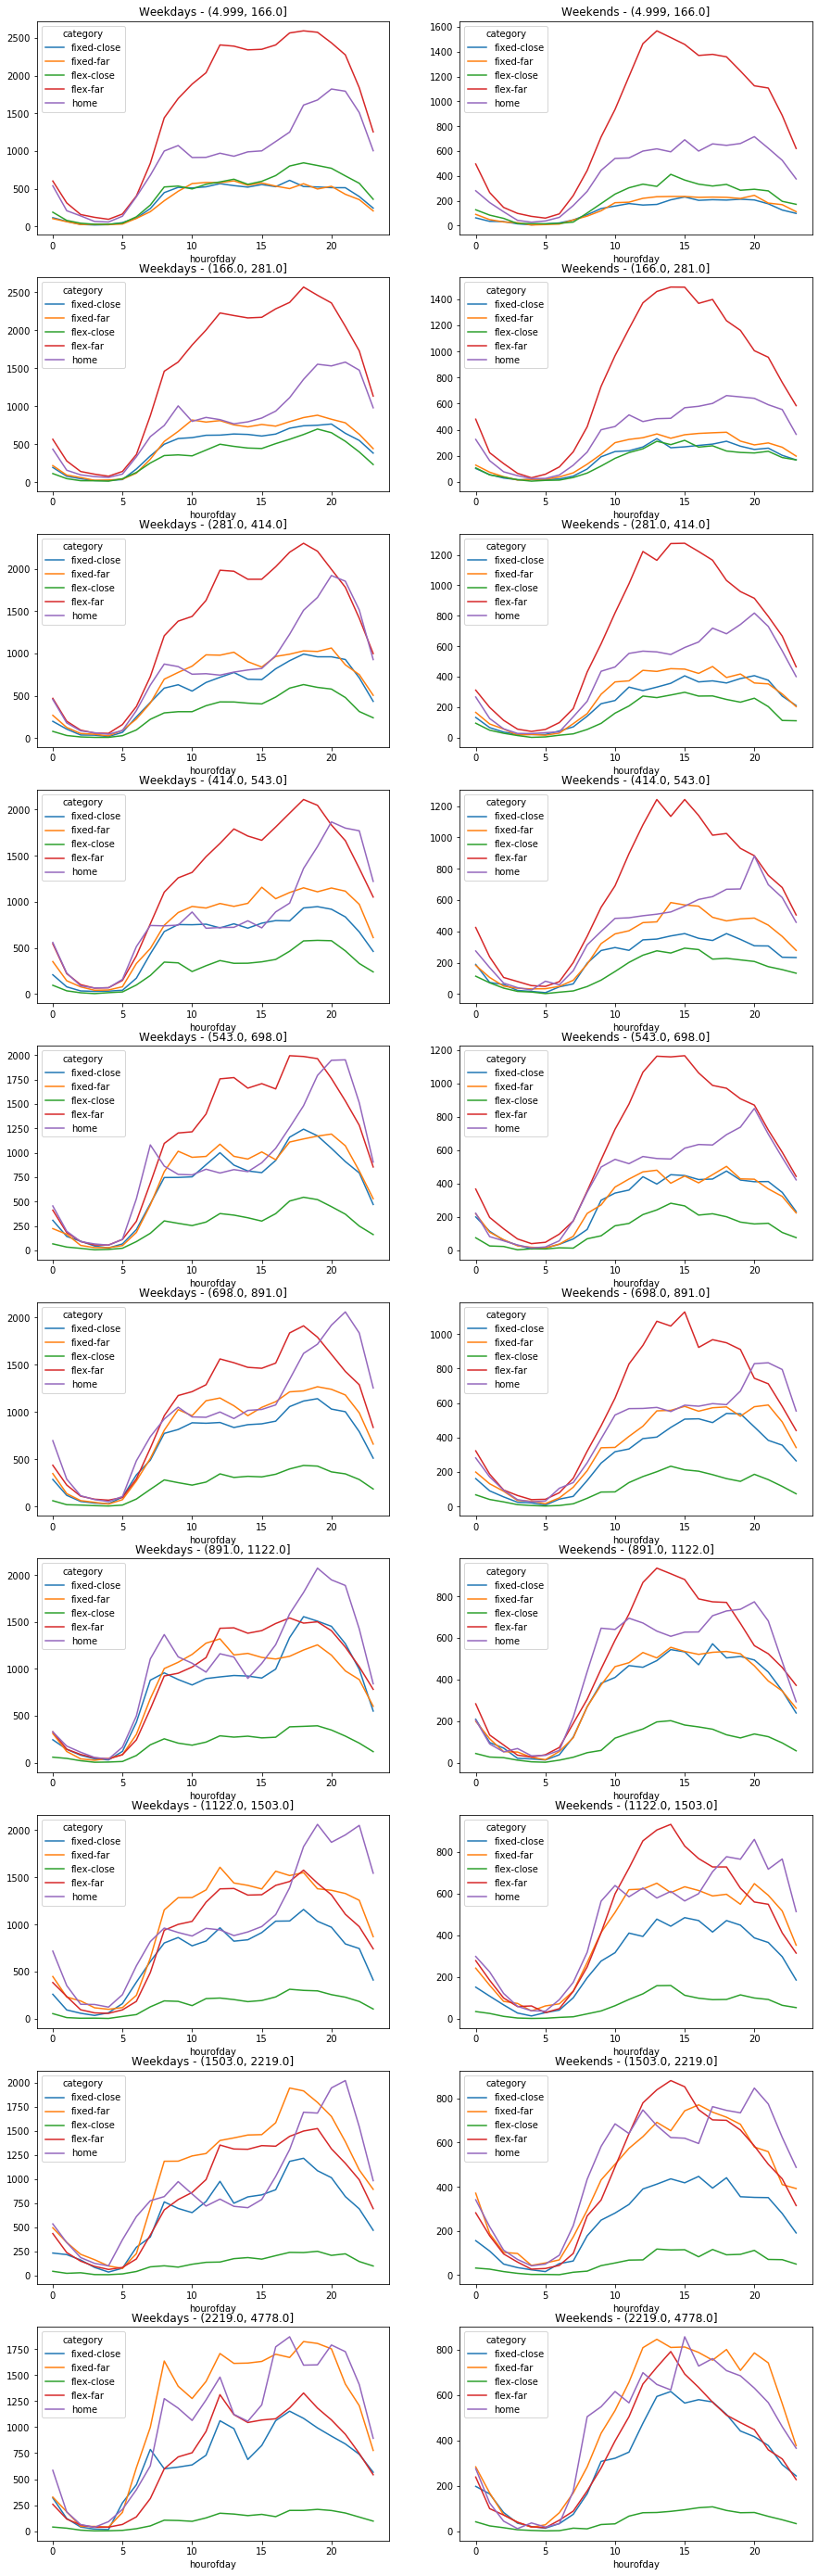

In [92]:
plot_category_distrib_quantiles(activities)